In [1]:
import numpy as np # type: ignore
import tensorflow as tf # type: ignore
import os
from tensorflow.keras.models import Model, load_model # type: ignore
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Reshape, Conv2DTranspose, Add, LeakyReLU, UpSampling2D, Dropout, Concatenate # type: ignore
from tensorflow.keras.optimizers import SGD, Adam # type: ignore
from tensorflow.keras.regularizers import l2 # type: ignore
from tensorflow.keras.optimizers.schedules import ExponentialDecay # type: ignore
from tensorflow.keras.losses import MeanSquaredError, CategoricalCrossentropy, MeanAbsoluteError # type: ignore
from tensorflow.keras.metrics import CategoricalAccuracy # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from tensorflow.keras.utils import to_categorical # type: ignore
import keras_tuner as kt # type: ignore
import matplotlib.pyplot as plt

In [2]:
def loss_ssim(y_true, y_pred):
    # Calculer le data_range
    data_range = tf.reduce_max(y_true) - tf.reduce_min(y_true)
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=data_range))

# Charger le modèle VGG16 pré-entraîné
vgg = tf.keras.applications.VGG16(include_top=False, weights='imagenet')

# Récupérer les noms des couches de convolution
layer_names = [layer.name for layer in vgg.layers if 'conv' in layer.name]

# Créer un dictionnaire pour stocker les modèles des couches de convolution
conv_layers = {}

# Stocker chacune des couches dans le dictionnaire
for i, layer_name in enumerate(layer_names):
    conv_layers[f'get_features_maps_{i}'] = tf.keras.Model(inputs=vgg.input, outputs=vgg.get_layer(layer_name).output)

def normalize(x):
    # Fonction min-max pour les Tensors
    min_val = tf.reduce_min(x)
    max_val = tf.reduce_max(x)
    return (x - min_val) / (max_val - min_val)

def lpips(batch_pred, batch_true):
    # Convertir les images en 3 canaux parce qu'elles sont en niveaux de gris
    batch_pred = tf.image.grayscale_to_rgb(batch_pred)
    batch_true = tf.image.grayscale_to_rgb(batch_true)

    # Appliquer le prétraitement VGG16 aux images
    batch_pred = tf.keras.applications.vgg16.preprocess_input(batch_pred)
    batch_true = tf.keras.applications.vgg16.preprocess_input(batch_true)

    # Initialiser la perte totale
    total_loss = 0.0

    # Extraire et normaliser les cartes de caractéristiques des deux images pour chaque couche de convolution
    for key in conv_layers.keys():
        pred_features = conv_layers[key](batch_pred)
        true_features = conv_layers[key](batch_true)
        total_loss += tf.reduce_mean(tf.square(pred_features - true_features))

    # Normaliser la perte totale
    total_loss /= len(conv_layers)

    """ # Ajouter la différence au niveau pixel
    pixel_diff = tf.reduce_mean(tf.square(batch_pred - batch_true))
    total_loss += pixel_diff """

    return total_loss

In [2]:
# Fonction qui genere des vecteurs aleatoires
def generate_unique_vectors(num_vectors, vector_length, vectors):
    vectors_list = []
    while len(vectors_list) < num_vectors:
        vector = tuple(np.random.randint(0, 2, vector_length))
        if vector not in vectors:
            vectors.add(vector)
            vectors_list.append(vector)
    return vectors_list, vectors

# Fonction qui convertie le generateur en tableau numpy
def generator_to_array(generator, class_vectors):
    samples = []
    vectors = []
    data_filenames = generator.filenames
    total_images = len(data_filenames)

    for i in range(len(generator)):
        batch = generator.next()
        batch_size = len(batch[0])

        for j in range(batch_size):
            index = i * generator.batch_size + j
            if index >= total_images:
                break  # Prevent going out of bounds

            samples.append(batch[0][j])
            class_name = data_filenames[index].split(os.path.sep)[0]
            vectors.append(class_vectors[class_name])
            
    return np.array(samples), np.array(vectors), data_filenames

# Fonction qui associe les images aux labels
def preprocess(train_generator, val_generator, num_classes, vector_length, total_vectors, use_random_vectors):
    class_indices = train_generator.class_indices
    
    if use_random_vectors:
        unique_vectors, total_vectors = generate_unique_vectors(num_classes, vector_length, total_vectors)
        class_vectors = {class_name: vector for class_name, vector in zip(class_indices, unique_vectors)}
    else:
        class_vectors = {class_name: i for i, class_name in enumerate(class_indices)}
    
    samples_train, vectors_train, _ = generator_to_array(train_generator, class_vectors)
    samples_val, vectors_val, _ = generator_to_array(val_generator, class_vectors)
    
    if not use_random_vectors:
        # Convert class indices to one-hot encoding
        vectors_train = to_categorical(vectors_train, num_classes=num_classes)
        vectors_val = to_categorical(vectors_val, num_classes=num_classes)
    
    return samples_train, vectors_train, samples_val, vectors_val, total_vectors

# Fonction qui charge les donnees
def load_data(datagen, target_size=(150, 150), batch_size=112, class_mode='input', shuffle=False, color_mode='grayscale', use_random_vectors=True, vector_length=56):
    ethnies = {'caucasians': [], 'afro_americans': [], 'asians': []}
    total_vectors = set()
    check = True
    for ethnie in ethnies.keys():
        trainset = datagen.flow_from_directory(f'../../Datasets/VGG/{ethnie}', target_size=target_size, batch_size=batch_size, class_mode=class_mode, shuffle=shuffle, color_mode=color_mode, subset='training')
        testset  = datagen.flow_from_directory(f'../../Datasets/VGG/{ethnie}', target_size=target_size, batch_size=batch_size, class_mode=class_mode, shuffle=shuffle, color_mode=color_mode, subset='validation')
        
        # Number of classes for one-hot encoding
        num_classes = len(trainset.class_indices)
        
        samples_train, vectors_train, samples_val, vectors_val, total_vectors = preprocess(trainset, testset, num_classes, vector_length, total_vectors, use_random_vectors)
        
        if trainset.n != samples_train.shape[0] or testset.n != samples_val.shape[0]:
            check = False
        ethnies[ethnie] = [trainset, testset, samples_train, vectors_train, samples_val, vectors_val]
    print(check)
    return ethnies

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.05, dtype='float16')

ethnies = load_data(datagen, target_size=(150, 150), use_random_vectors=False)

Found 3985 images belonging to 21 classes.
Found 199 images belonging to 21 classes.
Found 4231 images belonging to 22 classes.
Found 212 images belonging to 22 classes.
Found 4160 images belonging to 21 classes.
Found 208 images belonging to 21 classes.
True


In [3]:
def residual_block(x, filters):
    shortcut = x
    
    # Premier convolutionnel avec filtre 3x3
    x = Conv2D(filters, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    
    # Deuxième convolutionnel avec filtre 3x3
    x = Conv2D(filters, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = MaxPooling2D(2)(x)

    # Ajuster le shortcut si nécessaire
    if shortcut.shape[-1] != filters * 4:
        shortcut = Conv2D(filters, (1, 1), padding='same', use_bias=False)(shortcut)
        shortcut = MaxPooling2D(2)(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    # Ajouter le shortcut et appliquer l'activation finale
    x = Add()([x, shortcut])
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    
    return x

def residual_block_recon(x, filters, stride=1):
    shortcut = x
    
    # Premier convolutionnel transposé avec filtre 3x3
    x = Conv2DTranspose(filters, (3, 3), strides=stride, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    
    # Deuxième convolutionnel transposé avec filtre 3x3
    x = Conv2DTranspose(filters, (3, 3), strides=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    
    # Ajuster le shortcut si nécessaire
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2DTranspose(filters, (1, 1), strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    # Ajouter le shortcut et appliquer l'activation finale
    x = Add()([x, shortcut])
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    
    return x

def residual_bloc_resnext(x, i, filters):
    
    # Premier convolutionnel avec filtre 3x3
    x = Conv2D(filters//64, 1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    
    # Deuxième convolutionnel avec filtre 3x3
    x = Conv2D(filters//64, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = Conv2D(filters, 1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    
    return x

In [4]:
def resnext_block(x, filters, cardinality=32):
    dico = {}
    shortcut = x
    for i in range(cardinality):
        x = residual_bloc_resnext(x, i, filters)

    x = Concatenate()[x1,x2,x3]

    x = Add()([x, shortcut])
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)

In [ ]:
def create_autoencoder1(shape=(150, 150, 1), input_latent=512):   
    input_img = Input(shape=shape, name='input_image')

    # Encoder

    # Première convolution
    x = Conv2D(8, 5, strides=1, padding='same', use_bias=False)(input_img)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    print(x.shape, "1ere conv")
    #x = regularized_conv_block(input_tensor=x, filters=16, size=3)

    # Feature extraction
    x = residual_block(x, 16, 2)
    x = bottleneck_block(x, 16)
    x = dilated_conv_block(x, 16)
    #x = regularized_conv_block(input_tensor=x, filters=32, size=3)
    print(x.shape)

    x = residual_block(x, 32, 2)
    x = bottleneck_block(x, 32)
    x = dilated_conv_block(x, 32)
    #x = regularized_conv_block(x, 64, 3)

    print(x.shape)

    x = residual_block(x, 64, 2)    
    x = bottleneck_block(x, 64)
    x = dilated_conv_block(x, 64)
    print(x.shape)

    x = residual_block(x, 128, 4, 2)
    x = bottleneck_block(x, 128)
    x = dilated_conv_block(x, 128)
    print(x.shape)

    x = residual_block(x, 256, 4, 2)
    x = bottleneck_block(x, 256)
    x = dilated_conv_block(x, 256)
    print(x.shape)

    x = residual_block(x, 512, 4, 2)
    x = bottleneck_block(x, 512)
    x = dilated_conv_block(x, 512)
    print(x.shape)

    x = residual_block(x, 1024, 3, 2)
    x = bottleneck_block(x, 1024)
    x = dilated_conv_block(x, 1024)
    print(x.shape)

    x = Conv2D(input_latent, 3, strides=2, padding='same', use_bias=False)(x)
    print(x.shape, "espace latent")    

    # Espace latent
    latent_space_layer = Dense(input_latent, activation='relu', use_bias=False)(x)
    latent_space_layer_norm = BatchNormalization(name='latent_space_layer_norm')(latent_space_layer)

    # Reconstruction
    reshape_layer = Reshape(target_shape=(1, 1, input_latent))(latent_space_layer_norm)
    print(reshape_layer.shape, 'reshape_layer')
    x_recon = Conv2DTranspose(input_latent, 3, strides=1, padding='same', use_bias=False)(reshape_layer)
    x_recon = BatchNormalization()(x_recon)
    x_recon = Activation(LeakyReLU(alpha=0.1))(x_recon)

    x_recon = residual_block_recon(x_recon, 1024, 3, 2)
    x_recon = bottleneck_block_recon(x_recon, 1024)
    x_recon = dilated_conv_block_recon(x_recon, 1024)
    print(x_recon.shape)
    x_recon = residual_block_recon(x_recon, 512, 3, 2)
    x_recon = bottleneck_block(x_recon, 512)
    x_recon = dilated_conv_block_recon(x_recon, 512)
    print(x_recon.shape)
    x_recon = residual_block_recon(x_recon, 256, 3, 2)
    x_recon = bottleneck_block(x_recon, 256)
    x_recon = dilated_conv_block_recon(x_recon, 256)
    print(x_recon.shape)
    x_recon = residual_block_recon(x_recon, 128, 3, 2)
    x_recon = bottleneck_block(x_recon, 128)
    x_recon = dilated_conv_block_recon(x_recon, 128)
    print(x_recon.shape)
    x_recon = residual_block_recon(x_recon, 64, 3, 2)
    x_recon = bottleneck_block(x_recon, 64)
    x_recon = dilated_conv_block_recon(x_recon, 64)
    print(x_recon.shape)
    x_recon = residual_block_recon(x_recon, 32, 3, 2)
    x_recon = bottleneck_block(x_recon, 32)
    x_recon = dilated_conv_block_recon(x_recon, 32)
    print(x_recon.shape)
    x_recon = residual_block_recon(x_recon, 16, 3, 2)
    x_recon = bottleneck_block(x_recon, 16)
    x_recon = dilated_conv_block_recon(x_recon, 16)
    print(x_recon.shape)
    x_recon = Conv2DTranspose(8, 1, padding='same')(x_recon)
    
    x_recon = Conv2DTranspose(1, (1, 1), padding='same', activation='sigmoid')(x_recon)
    print(x_recon.shape)
    x_recon = tf.keras.layers.Resizing(height=150, width=150, name='recon_image')(x_recon)
    print(x_recon.shape, 'affiche')
    

    lr_schedule = ExponentialDecay(initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.9, staircase=True)
    optimizer = SGD(learning_rate=lr_schedule, momentum=0.9)

    model = Model(inputs=input_img, outputs=x_recon)
    model.compile(optimizer=optimizer, loss='mse')

    return model

model = create_autoencoder1()
model.summary()


In [ ]:
def create_autoencoder2(shape=(150, 150, 1), input_latent=512):   
    input_img = Input(shape=shape, name='input_image')
    nbr_filters = [32, 64, 128, 256, 512, 1024, 2048]
    # Encoder

    # Première convolution
    x = Conv2D(32, 5, strides=1, padding='same', use_bias=False)(input_img)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    print(x.shape, "1ere conv")

    for filters in nbr_filters:
        x = residual_block(x, filters, 2)
        x = bottleneck_block(x, filters)
        x = dilated_conv_block(x, filters)
        print(x.shape)

    x = Conv2D(input_latent, 3, strides=2, padding='same', use_bias=False)(x)
    print(x.shape, "espace latent")    

    # Espace latent
    latent_space_layer = Dense(input_latent, activation='relu', use_bias=False)(x)
    latent_space_layer_norm = BatchNormalization(name='latent_space_layer_norm')(latent_space_layer)

    # Reconstruction
    reshape_layer = Reshape(target_shape=(1, 1, input_latent))(latent_space_layer_norm)
    print(reshape_layer.shape, 'reshape_layer')
    x_recon = Conv2DTranspose(input_latent, 3, strides=1, padding='same', use_bias=False)(reshape_layer)
    x_recon = BatchNormalization()(x_recon)
    x_recon = Activation(LeakyReLU(alpha=0.1))(x_recon)

    for filters in reversed(nbr_filters):
        x_recon = residual_block_recon(x_recon, filters, 2)
        x_recon = bottleneck_block_recon(x_recon, filters)
        x_recon = dilated_conv_block_recon(x_recon, filters)
        print(x_recon.shape)
    
    x_recon = Conv2DTranspose(32, 1, padding='same')(x_recon)
    
    x_recon = Conv2DTranspose(1, (1, 1), padding='same', activation='sigmoid')(x_recon)
    print(x_recon.shape)
    x_recon = tf.keras.layers.Resizing(height=150, width=150, name='recon_image')(x_recon)
    print(x_recon.shape, 'affiche')
    

    lr_schedule = ExponentialDecay(initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.9, staircase=True)
    optimizer = SGD(learning_rate=lr_schedule, momentum=0.9)

    model = Model(inputs=input_img, outputs=x_recon)
    model.compile(optimizer=optimizer, loss='mse')

    return model

autoencodeur = create_autoencoder2()
autoencodeur.summary()


In [4]:
def create_autoencodeur3(shape=(150, 150, 1), input_latent=512, len_vecteur=22):
    nbr_filters = [64, 128, 256, 512, 1024, 2048]
    input_img = Input(shape=shape, name='input_image')
    print(shape)
    x = Conv2D(32, 2, strides = 1, padding='same', use_bias=False)(input_img)
    x = BatchNormalization()(x)
    x = Activation(LeakyReLU(alpha=0.1))(x)
    x = MaxPooling2D(2)(x)
    print(x.shape)

    #encoder
    for filtres in nbr_filters:
        x = residual_block(x, filtres)
        print(x.shape)
    x = Conv2D(input_latent, 2, padding='same', use_bias=False)(x)
    print(x.shape)
    x = Flatten()(x)

    # Espace latent
    latent_space_layer = Dense(input_latent, activation='relu', use_bias=False)(x)
    latent_space_layer_norm = BatchNormalization(name='latent_space_layer_norm')(latent_space_layer)

    # Reconstruction
    reshape_layer = Reshape(target_shape=(1, 1, input_latent))(latent_space_layer_norm)
    print(reshape_layer.shape, 'reshape_layer')
    x_recon = Conv2DTranspose(input_latent, 3, strides=1, padding='same', use_bias=False)(reshape_layer)
    x_recon = BatchNormalization()(x_recon)
    x_recon = Activation(LeakyReLU(alpha=0.1))(x_recon)
    print(x_recon.shape, "premieretranspo")

    for filtres in reversed(nbr_filters):
        x_recon = residual_block_recon(x_recon, filtres, 2)
        print(x_recon.shape)
    x_recon = residual_block_recon(x_recon, 32, 2)
    print(x_recon.shape)
    x_recon = Conv2DTranspose(1, (1, 1), padding='same', activation='sigmoid')(x_recon)
    print(x_recon.shape)
    x_recon = tf.keras.layers.Resizing(height=shape[0], width=shape[1], name='recon_image')(x_recon)
    print(x_recon.shape, 'affiche')

    model = Model(inputs=input_img, outputs=x_recon)
    
    lr_schedule = ExponentialDecay(initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.9, staircase=True)

    optimizer = SGD(learning_rate=lr_schedule, momentum=0.9)
    model.compile(optimizer=optimizer, loss=MeanAbsoluteError())
    return model

auto = create_autoencodeur3()
auto.summary()

(150, 150, 1)
(None, 75, 75, 32)
(None, 37, 37, 64)
(None, 18, 18, 128)
(None, 9, 9, 256)
(None, 4, 4, 512)
(None, 2, 2, 1024)
(None, 1, 1, 2048)
(None, 1, 1, 512)
(None, 1, 1, 512) reshape_layer
(None, 1, 1, 512) premieretranspo
(None, 2, 2, 2048)
(None, 4, 4, 1024)
(None, 8, 8, 512)
(None, 16, 16, 256)
(None, 32, 32, 128)
(None, 64, 64, 64)
(None, 128, 128, 32)
(None, 128, 128, 1)
(None, 150, 150, 1) affiche
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 150, 150, 32  128         ['input_ima

In [5]:
# Définir un callback personnalisé pour afficher la reconstruction toutes les 10 époques
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, test_data, display_loss_interval=20, display_recon_interval=50):
        super().__init__()
        self.model = model
        self.test_data = test_data
        self.display_loss_interval = display_loss_interval
        self.display_recon_interval = display_recon_interval

    def on_epoch_end(self, epoch, logs):
        if epoch % self.display_recon_interval == 0:
            reconstructions = self.model.predict(self.test_data, verbose = 0)
            self.display_reconstruction(epoch+1, self.test_data, reconstructions)
        if epoch % self.display_loss_interval == 0:
            print(f"Epoch {epoch+1}, Loss: {logs['loss']:.4g}")


    def display_reconstruction(self, epoch, originals, reconstructions):
        n = 10  # Number of images to display
        plt.figure(figsize=(20, 4))
        for i in range(n):
            # Display original
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(originals[i].reshape(150, 150), cmap='gray')
            plt.title("Original")
            plt.axis('off')
            
            # Display reconstruction
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(reconstructions[i].reshape(150, 150), cmap='gray')
            plt.title("Reconstructed")
            plt.axis('off')
        plt.suptitle(f'Epoch {epoch}')
        plt.savefig(f'Results/MAE/{epoch}.png')

ethnie = 'caucasians'
x_train = ethnies[ethnie][2] ; y_train = ethnies[ethnie][3]
x_val   = ethnies[ethnie][4] ; y_val   = ethnies[ethnie][5]
x_print = x_val.copy(); np.random.shuffle(x_print); x_print = x_print[:10]
# Entraîner le modèle avec le callback personnalisé
auto.fit(x_train, x_train, epochs=801, shuffle=True, batch_size=4, callbacks=[CustomCallback(auto, x_print)], verbose=1) #

Epoch 1/801


ResourceExhaustedError: in user code:

    File "c:\Users\guilh\anaconda3\envs\envguilhem\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\guilh\anaconda3\envs\envguilhem\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\guilh\anaconda3\envs\envguilhem\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\guilh\anaconda3\envs\envguilhem\lib\site-packages\keras\engine\training.py", line 997, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\guilh\anaconda3\envs\envguilhem\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 579, in minimize
        return self.apply_gradients(grads_and_vars, name=name)
    File "c:\Users\guilh\anaconda3\envs\envguilhem\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 695, in apply_gradients
        self._create_all_weights(var_list)
    File "c:\Users\guilh\anaconda3\envs\envguilhem\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 959, in _create_all_weights
        self._create_slots(var_list)
    File "c:\Users\guilh\anaconda3\envs\envguilhem\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py", line 136, in _create_slots
        self.add_slot(var, "momentum")
    File "c:\Users\guilh\anaconda3\envs\envguilhem\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 1050, in add_slot
        weight = tf.Variable(
    File "c:\Users\guilh\anaconda3\envs\envguilhem\lib\site-packages\keras\initializers\initializers_v2.py", line 171, in __call__
        return tf.zeros(shape, dtype)

    ResourceExhaustedError: {{function_node __wrapped__Fill_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[3,3,2048,2048] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Fill]


In [6]:
auto.save("auto_mae.hdf5")

In [7]:
autoencodeur = load_model('auto_mse.hdf5')

126/126 [==============================] - 22s 171ms/step - loss: 0.0636

Epoch 106/201
126/126 [==============================] - 29s 231ms/step - loss: 0.0337 (MSE)

In [8]:
x_val_predict = auto.predict(x_val)

7/7 [==============================] - 4s 278ms/step


In [13]:
x_train_predict = auto(x_train[:31]).numpy()

NameError: name 'x_train_predict' is not defined

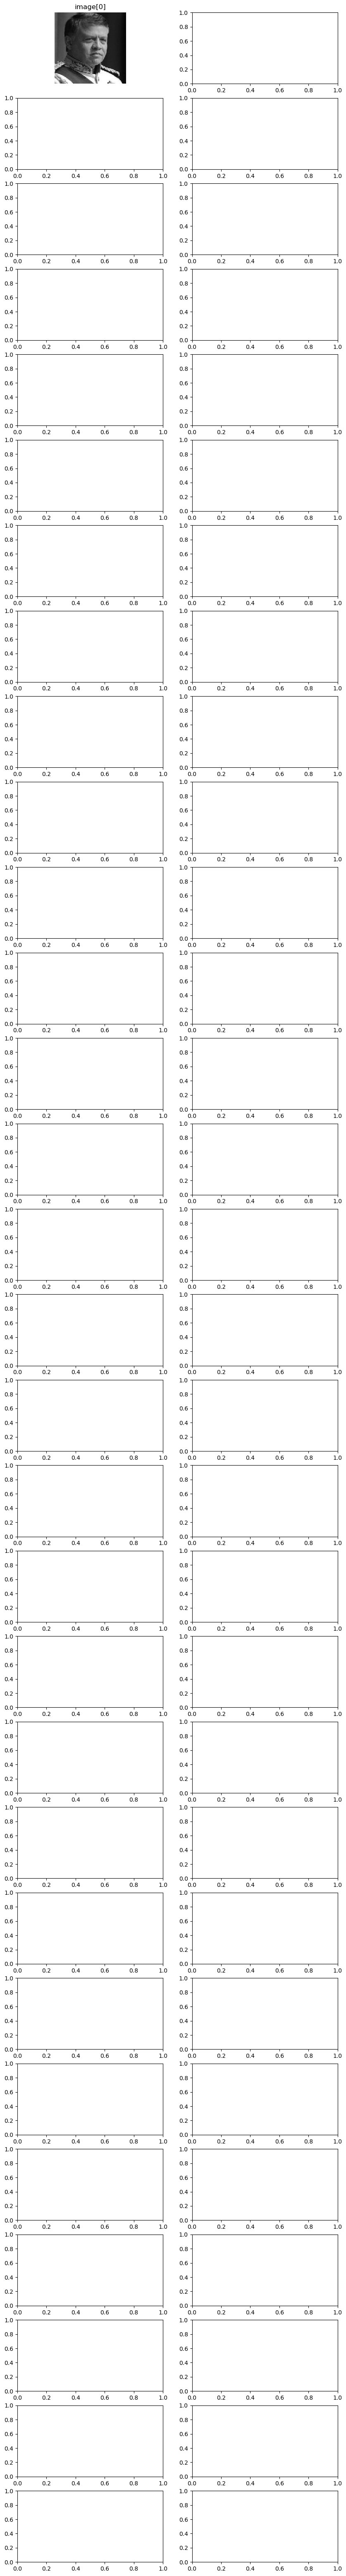

In [9]:
# Définir le nombre de lignes et de colonnes
rows = len(x_val)  # nombre d'images à afficher
cols = 2  # 2 colonnes, une pour l'image et une pour sa prédiction

fig, axes = plt.subplots(30, cols, figsize=(10, 80))

# Afficher les images dans la grille avec des légendes
for i in range(30):
    # Afficher l'image de x_val
    ax_val = axes[i, 0]
    ax_val.imshow(x_train[i], cmap='grey')
    ax_val.set_title(f'image[{i}]')
    ax_val.axis('off')
    
    # Afficher l'image de x_train
    ax_train = axes[i, 1]
    ax_train.imshow(x_train_predict[i], cmap='grey')
    ax_train.set_title(f'reconstruction[{i}]')
    ax_train.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def create_classifier(shape=(256, 256, 1), input_latent=512, len_vecteur=56):
    nbr_filters = [32, 64, 128, 256, 512, 1024, 2048]
    input_img = Input(shape=shape, name='input_image')
    x = Conv2D(16, 3, strides=2, padding='same', use_bias=False)(input_img)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    #encoder
    for filtres in nbr_filters:
        x = residual_block(x, filtres, 3, 2)
        print(x.shape)
    x = residual_block(x, input_latent, 3, 1)
    print(x.shape)
    x = Flatten()(x)

    # Espace latent
    latent_space_layer = Dense(input_latent, activation='relu', use_bias=False)(x)
    latent_space_layer_norm = BatchNormalization(name='latent_space_layer_norm')(latent_space_layer)

    # Classification
    x_class = Dense(50, activation='relu', kernel_regularizer=l2(0.01))(latent_space_layer_norm)
    x_class = BatchNormalization()(x_class)
    x_class = Dropout(0.25)(x_class)
    x_class = Dense(25, activation='relu', kernel_regularizer=l2(0.01))(x_class)
    x_class = BatchNormalization()(x_class)
    x_class = Dropout(0.25)(x_class)
    x_class = Dense(len_vecteur, activation='softmax', name='classif')(x_class)

    model = Model(inputs=input_img, outputs=x_class)
    
    lr_schedule = ExponentialDecay(initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.9, staircase=True)

    optimizer = SGD(learning_rate=lr_schedule, momentum=0.9)
    model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=CategoricalAccuracy())
    return model

In [ ]:
predictions = model_autoencoder.predict(x_val)
x_val_predict = predictions

In [ ]:
get_latent = tf.keras.Model(inputs=model_autoencoder.input, outputs=model_autoencoder.get_layer('latent_space_layer_norm').output)

In [ ]:
afro_americans_latent = get_latent.predict(x_val).reshape(x_val.shape[0], 512)
caucasian_latent = get_latent.predict(ethnies['caucasians'][-2]).reshape(ethnies['caucasians'][-2].shape[0], 512)
asians_latent = get_latent.predict(ethnies['asians'][-2]).reshape(ethnies['asians'][-2].shape[0], 512)

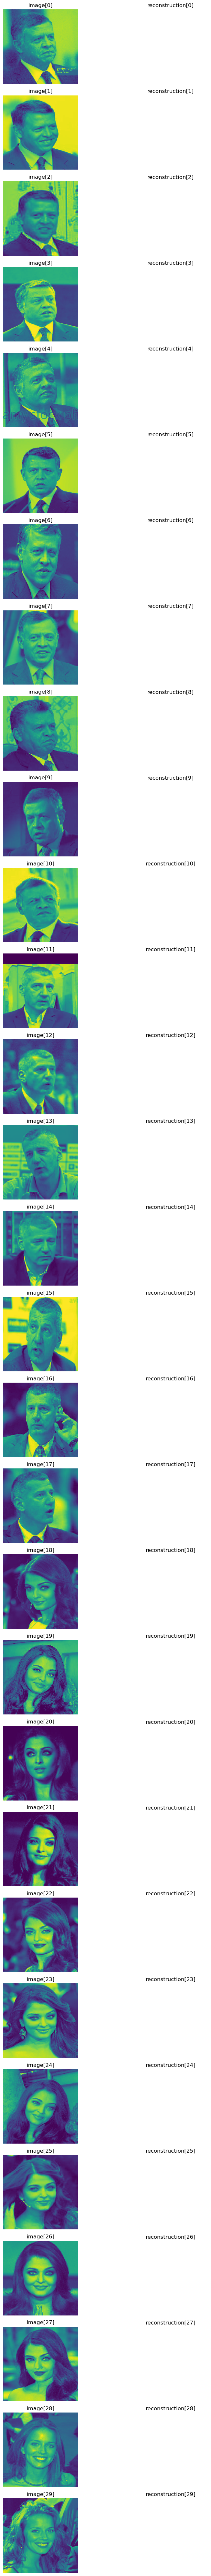

In [16]:
# Définir le nombre de lignes et de colonnes
rows = len(x_val)  # nombre d'images à afficher
cols = 2  # 2 colonnes, une pour l'image et une pour sa prédiction

fig, axes = plt.subplots(30, cols, figsize=(10, 80))

# Afficher les images dans la grille avec des légendes
for i in range(30):
    # Afficher l'image de x_val
    ax_val = axes[i, 0]
    ax_val.imshow(x_val[i])
    ax_val.set_title(f'image[{i}]')
    ax_val.axis('off')
    
    # Afficher l'image de x_train
    ax_train = axes[i, 1]
    ax_train.imshow(x_val_predict[i])
    ax_train.set_title(f'reconstruction[{i}]')
    ax_train.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.decomposition import PCA


def pca(dico_latent, ethnie):
    scatters = []
    pca = PCA(n_components=2)
    plt.figure(figsize=(10, 8))
    for latent in dico_latent.keys():
        latent_pca = pca.fit_transform(dico_latent[latent][0])
        dico_latent[latent].append(latent_pca)  # ajout de latent_pca
        scatter = plt.scatter(latent_pca[:, 0], latent_pca[:, 1], alpha=0.5, label=latent)
        scatters.append(scatter)
    plt.legend(handles=scatters)
    plt.title(f'Projection ACP de l espace latent {ethnie}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

    return dico_latent

dico_latent = {'afro_americans': [afro_americans_latent], 
               'caucasians': [caucasian_latent], 
               'asians': [asians_latent]}

dico_latent = pca(dico_latent, "afro_americans")

In [ ]:
def calculate_mean_dispersion(latent_representations):
    centroid = np.mean(latent_representations, axis=0)
    distance_squared = np.sum((latent_representations - centroid)**2, axis = 1)
    return np.mean(distance_squared)

def comparaison_dispersion(dico_latent):
    for ethnie in dico_latent.keys():
        dispersion = calculate_mean_dispersion(dico_latent[ethnie][1])
        print(f"Moyenne des dispersions des espaces latents pour les individus {ethnie} : {dispersion}")

comparaison_dispersion(dico_latent)

In [6]:
def coef_bhattacharyya(P, Q):
    P = P / np.sum(P)
    Q = Q / np.sum(Q)
    return np.sum(np.sqrt(P * Q))

coef_bhattacharyya(dico_latent['caucasien'], dico_latent['afro_americans'])

def coef_B(dico_latent):
    ethnies = dico_latent.keys()
    for i in range(len(dico_latent.keys())):
        for j in range(i + 1, len(dico_latent)):
            ethnie1 = dico_latent[i]
            ethnie2 = dico_latent[j]
            coef = coef_bhattacharyya(dico_latent[ethnie1][0], dico_latent[ethnie2][0])
            print(f"Coef entre {ethnie1} et {ethnie2} : {coef}")

coef_B(dico_latent)

NameError: name 'dico_latent' is not defined